In [12]:
import src.dataPipeline as dataPipeline
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import optuna

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold,StratifiedKFold
# Evaluating the model
from sklearn.metrics import accuracy_score, make_scorer, f1_score, recall_score, precision_score
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

importlib.reload(dataPipeline)


<module 'src.dataPipeline' from 'C:\\Users\\wartm\\Documents\\FHNW\\immo_challenge\\src\\dataPipeline.py'>

In [13]:
dp = dataPipeline.DataPipeline()
df = dp.runPipeline(
    filePath="../../data/immo_data_202208_v2.csv",
    imputer=None,
    normalizeAndStandardize= False,
    basic_house_imputer = True,
    get_dummies = False
)

C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:44: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:71: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].bfill(axis=1)['Space extracted']
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:76: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in 

In [14]:
df.head()

,Availability,Floor,detail_responsive#surface_usable,Floor_space_merged,ForestDensityL,ForestDensityM,ForestDensityS,NoisePollutionRailwayL,NoisePollutionRailwayM,NoisePollutionRailwayS,...,gde_workers_total,price_cleaned,Space extracted,type_unified,Plot_area_unified,No. of rooms:,Last refurbishment:,Year built:,Number of floors:,region_group
0,On request,4.0,0.0,NaN,0.511176,0.286451,0.090908,0.0,0.0,0.0,...,331.0,1150000.0,100.0,penthouse,0.0,5.0,NaN,NaN,1.0,51.0
1,On request,0.0,0.0,242.0,0.511176,0.286451,0.090908,0.0,0.0,0.0,...,331.0,1420000.0,156.0,terrace-house,222.0,5.0,NaN,NaN,1.0,51.0
2,Immediately,2.0,0.0,NaN,0.163362,0.095877,0.001911,0.0,0.0,0.0,...,33493.0,720000.0,93.0,penthouse,0.0,5.0,NaN,NaN,1.0,51.0
3,On request,0.0,0.0,257.0,0.511176,0.286451,0.090908,0.0,0.0,0.0,...,331.0,1430000.0,154.0,detached-house,370.0,5.0,NaN,NaN,1.0,51.0
4,On request,0.0,0.0,NaN,0.333865,0.279276,0.145835,0.0,0.0,0.0,...,1355.0,995000.0,142.0,flat,0.0,5.0,NaN,NaN,1.0,51.0


# secondary suit und detached house zusammenfassen

In [15]:
df["type_unified"].value_counts()

type_unified
flat                              10119
detached-house                     5021
villa                              1133
semi-detached-house                 789
duplex-maisonette                   674
chalet                              655
attic-flat                          651
penthouse                           607
terrace-house                       482
stepped-apartment                   203
farmhouse                           151
studio                               92
rustico                              64
stepped-house                        57
loft                                 39
furnished-residential-property       24
attic-room                           12
castle                                6
detached-secondary-suite              4
single-room                           2
secondary-suite                       1
Name: count, dtype: int64

In [16]:
merge_mapping = {
    'attic-room': 'attic-flat',
    'castle': 'farmhouse',
    'detached-secondary-suite': 'detached-house',
    'single-room': 'studio',
    'secondary-suite': 'duplex-maisonette'
}

df['type_unified'] = df['type_unified'].replace(merge_mapping)

In [17]:
df["region_group"] = df["region_group"].astype("category")
df["Availability"] = df["Availability"].astype("category")

In [18]:
X = df.drop("type_unified", axis=1)
y = df["type_unified"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
cat_col = ['region_group', 'Availability']
numerical_features = [col for col in df.columns if col not in cat_col + ["type_unified"]]

# Preprocessing für numerische Daten
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),  # Fehlwerte auffüllen
    ('scaler', StandardScaler())  # Standardisieren
])

# Preprocessing für kategorische Daten
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fehlwerte auffüllen
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot-Encoding
])

# ColumnTransformer erstellen
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, cat_col)
    ]
)

# Pipeline nur für das Preprocessing erstellen
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

In [20]:
# Define cross-validator
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics to collect
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []

# Iterate through the folds
for train_index, val_index in kf.split(X_train, y_train):
    # Split original data into train and validation sets
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Transform train and validation sets
    X_fold_train_transformed = pipeline.fit_transform(X_fold_train)
    X_fold_val_transformed = pipeline.transform(X_fold_val)

    # Train the model
    logistic = LogisticRegression(max_iter=1000)
    logistic.fit(X_fold_train_transformed, y_fold_train)

    # Predict on the validation set
    y_val_pred = logistic.predict(X_fold_val_transformed)

    # Calculate metrics
    accuracy_scores.append(accuracy_score(y_fold_val, y_val_pred))
    f1_scores.append(f1_score(y_fold_val, y_val_pred, average='weighted'))
    recall_scores.append(recall_score(y_fold_val, y_val_pred, average='weighted'))
    precision_scores.append(precision_score(y_fold_val, y_val_pred, average='weighted'))

C:\Users\wartm\Documents\FHNW\immo_challenge\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wartm\Documents\FHNW\immo_challenge\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wartm\Documents\FHNW\immo_challenge\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [21]:
# Print aggregated metrics
print(f"Mean Accuracy: {np.mean(accuracy_scores):.4f} and std: {np.std(accuracy_scores):.4f}")
print(f"Mean F1-Score: {np.mean(f1_scores):.4f} and std: {np.std(f1_scores):.4f}")
print(f"Mean Recall: {np.mean(recall_scores):.4f} and std: {np.std(recall_scores):.4f}")
print(f"Mean Precision: {np.mean(precision_scores):.4f} and std: {np.std(precision_scores):.4f}")


Mean Accuracy: 0.6891 and std: 0.0029
Mean F1-Score: 0.6120 and std: 0.0042
Mean Recall: 0.6891 and std: 0.0029
Mean Precision: 0.5864 and std: 0.0086


In [22]:
# Model
logistic = LogisticRegression(max_iter=1000)
logistic.fit(X_train_transformed, y_train)


LogisticRegression(max_iter=1000)

In [23]:
# Evaluate the model
y_pred = logistic.predict(X_test_transformed)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

C:\Users\wartm\Documents\FHNW\immo_challenge\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
print(f"Accuracy: {acc}")
print(f"F1-Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

Accuracy: 0.6940836940836941
F1-Score: 0.619733119606046
Recall: 0.6940836940836941
Precision: 0.6100346214597128


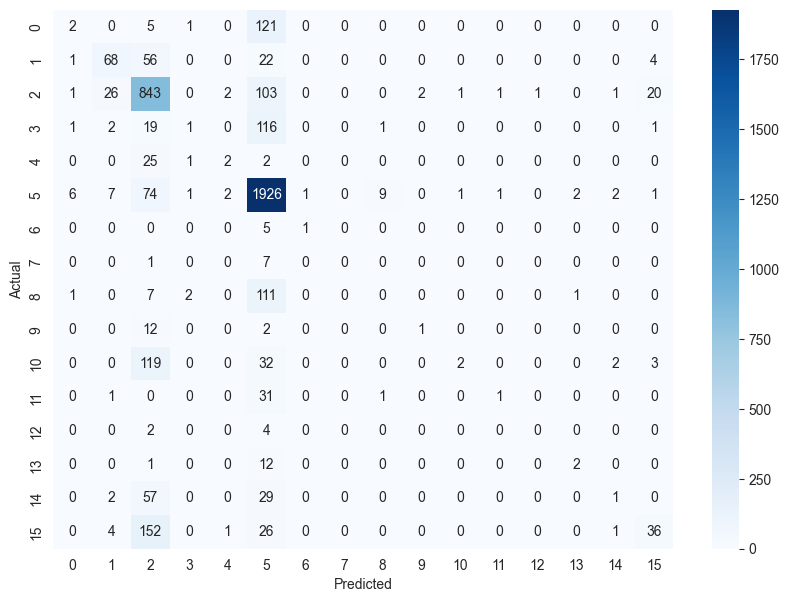

In [25]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred, labels=logistic.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Smote upsampling

In [26]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

In [27]:
# Model
logistic = LogisticRegression(max_iter=1000)
logistic.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000)

In [28]:
# Evaluate the model
y_pred = logistic.predict(X_test_transformed)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

In [29]:
print(f"Accuracy: {acc}")
print(f"F1-Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

Accuracy: 0.3136123136123136
F1-Score: 0.37060775595760675
Recall: 0.3136123136123136
Precision: 0.6644841063739451


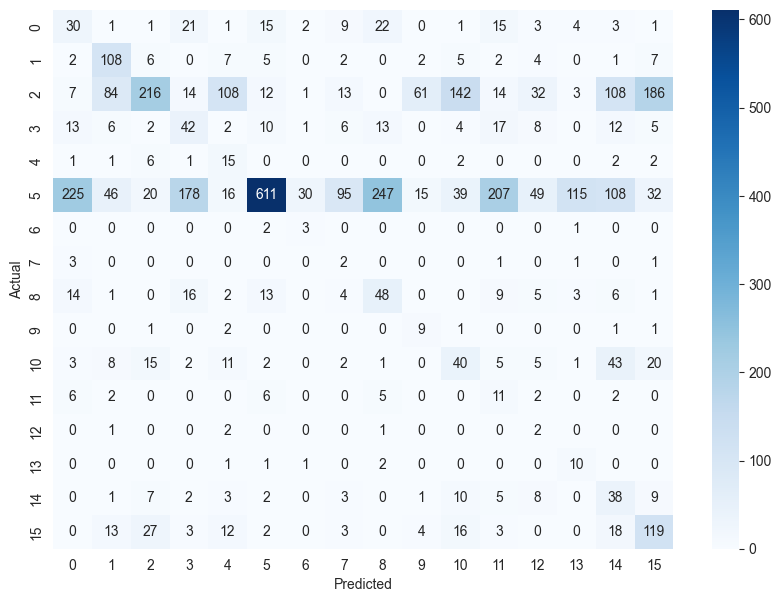

In [30]:
cm = confusion_matrix(y_test, y_pred, labels=logistic.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()